# Notebook - Statistical Arbitrage Example


*Notebook for the paper [Reinforcement Learning with Dynamic Convex Risk Measures](https://arxiv.org/abs/2112.13414), by [Anthony Coache](https://anthonycoache.ca/) and [Sebastian Jaimungal](http://sebastian.statistics.utoronto.ca/).*

This code notebook showcases how to use the Python files in order to reproduce some of the main figures of the statistical arbitrage example. Note that the code architecture is similar between all sets of experiments, and the code for each example is available in separate folders on our [Github repository](https://github.com/acoache/RL-DynamicConvexRisk):
- **StatArbitrage**: Statistical Arbitrage Example
- **CliffWalking**: Cliff Walking Example
- **Hedging**: Hedging with Friction Example

## 1. Importation of Python Libraries

First, our code requires us to import several Python packages, such as NumPy, PyTorch, SciPy, Matplotlib, os, time, as well as some of our classes as modules. Note here that we would need to change the prefix of the modules for the folder name of the corresponding example we want to reproduce.

In [1]:
# numpy
import numpy as np
import numpy.matlib

# plotting
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

# pytorch
import torch as T
import torch.optim as optim

# personal files
import StatArbitrage.utils as utils
import StatArbitrage.hyperparams as hyperparams
from StatArbitrage.models import PolicyApprox, ValueApprox
from StatArbitrage.risk_measure import RiskMeasure
from StatArbitrage.envs import TradingEnv
from StatArbitrage.actor_critic import ActorCriticPG

# misc
import time
import os

## 2. Initialization of Training Parameters

This section deals with the initialization of all hyperparameters, located in the **hyperparams.py** file. We can set the name of the repository, parameters that modify the environment -- e.g. number of periods, asset price dynamics model, etc. -- and hyperparameters that affect our actor-critic algorithm -- e.g. number of epochs, learning rates, etc. We also print the parameters prior to the training in order to verify their correctness.

In [2]:
# initialize parameters for the model and algorithm
repo, envParams, algoParams = hyperparams.initParams()

# print all parameters for reproducibility purposes
print('\n*** Name of the repository: ', repo, ' ***\n')
hyperparams.printParams(envParams, algoParams)


*** Name of the repository:  StatArbitrage_ex1  ***

*  T:  1  Ndt:  6  kappa:  2  sigma:  0.2  theta:  1  phi:  0.005  psi:  0.5  max_q:  5  max_u:  2
*  Ntrajectories:  500  Mtransitions:  500  Nepochs:  300  Nsims_optimal:  1000
*  Nepochs_V_init:  500  Nepochs_V:  50  lr_V:  0.001  batch_V:  200  hidden_V:  32  layers_V:  4
*  Nepochs_pi:  10  lr_pi:  0.001  batch_pi:  200  hidden_pi:  32  layers_pi:  3


We also specify the risk measures that we want to evaluate. For instance, here, we will perform the optimization on three risk measures:

1. the expectation;
2. the dynamic CVaR at level $\alpha=0.5$;
3. the dynamic CVaR at level $\alpha=0.2$.

One can also add other (dynamic) risk measures in the **risk_measure.py** file.

In [3]:
# specify the risk measures
rm_list = ['mean', 'CVaR', 'CVaR']
alpha_cvar = [-99, 0.5, 0.2] # threshold for the conditional value-at-risk

print_progress = 200 # number of epochs before printing the time/loss

utils.directory(repo) # creation of the main repository to store results

We initialize the environment object, that is common to all optimization problems. Finally, we define labels for all risk measures that we will use later, whether for folder names when storing results or legends when plotting figures.

In [4]:
# create the environment and risk measure objects
env = TradingEnv(envParams)

# labels to use for the figures in the testing phase
rm_labels = []

for idx_method, method in enumerate(rm_list):
    
    if(method == 'mean'):
        rm_label = method
    if(method == 'CVaR'):
        rm_label = method + str( round(alpha_cvar[idx_method],3) )
    
    rm_labels.append(rm_label)
    
    # create a subfolder to store results
    utils.directory(repo + '/' + rm_label)

# print labels
print(rm_labels)

['mean', 'CVaR0.5', 'CVaR0.2']


## 3. Training our Agents

Once we validate all the parameters, we can start the training phase of our actor-critic algorithm. This corresponds to the Algorithms 2 and 3 presented in Section 6 of our [paper](https://arxiv.org/abs/2112.13414). We loop through all the risk measures and perform the optimization by alternating between

1. Estimating the value function of the current policy;
2. Updating the policy by policy gradient.

When the training is completed, we save the ANNs for both the policy and the value function in the corresponding subfolder. In the corresponding folders, one can also print progress in the console and plot some diagnostic figures during the training phase.

In [ ]:
for idx_method, method in enumerate(rm_list):
    # print progress
    print('\n*** Method = ', method, ' ***\n')
    start_time = time.time()

    # create the risk measure object
    risk_measure = RiskMeasure(Type=method, alpha=alpha_cvar[idx_method])

    # create ANNs for both the policy & value function
    policy = PolicyApprox(3, env,
                            n_layers=algoParams["layers_pi"],
                            hidden_size=algoParams["hidden_pi"],
                            learn_rate=algoParams["lr_pi"])
    value_function = ValueApprox(3, env,
                            n_layers=algoParams["layers_V"],
                            hidden_size=algoParams["hidden_V"],
                            learn_rate=algoParams["lr_V"])
    
    # initialize the actor-critic algorithm
    actor_critic = ActorCriticPG(repo=repo,
                                    method=rm_labels[idx_method],
                                    env=env,
                                    policy=policy,
                                    V=value_function,
                                    risk_measure=risk_measure,
                                    gamma=algoParams["gamma"])
    
    ##############################################################################
    ###########################     TRAINING PHASE     ###########################
    
    # first estimate of the value function
    actor_critic.estimate_V(Ntrajectories=algoParams["Ntrajectories"],
                                Mtransitions=algoParams["Mtransitions"],
                                batch_size=algoParams["batch_V"],
                                Nepochs=algoParams["Nepochs_V_init"],
                                rng_seed=algoParams["seed"])

    for epoch in range(algoParams["Nepochs"]):
        # estimate the value function of the current policy
        actor_critic.estimate_V(Ntrajectories=algoParams["Ntrajectories"],
                                    Mtransitions=algoParams["Mtransitions"],
                                    batch_size=algoParams["batch_V"],
                                    Nepochs=algoParams["Nepochs_V"],
                                    rng_seed=algoParams["seed"])
        
        # update the policy by policy gradient
        actor_critic.update_policy(Ntrajectories=algoParams["Ntrajectories"],
                                    Mtransitions=algoParams["Mtransitions"],
                                    batch_size=algoParams["batch_pi"],
                                    Nepochs=algoParams["Nepochs_pi"],
                                    rng_seed=algoParams["seed"])

        # print progress
        if epoch % print_progress == 0 or epoch == algoParams["Nepochs"] - 1:
            print('*** Epoch = ', str(epoch) ,
                    ' completed, Duration = ', "{:.3f}".format(time.time() - start_time), ' secs ***')
            start_time = time.time()

    # save the neural network
    T.save(actor_critic.policy.state_dict(),
            repo + '/' + rm_labels[idx_method] + '/policy_model.pt')
    T.save(actor_critic.V.state_dict(),
            repo + '/' + rm_labels[idx_method] + '/V_model.pt')

    # print progress
    print('*** Training phase completed! ***')
    
    ###########################     END OF TRAINING     ##########################
    ##############################################################################

## 4. Initialization of Testing Parameters

This section allows us to set the number of trajectories, the seed for the random generator of both NumPy and PyTorch, and the style of the figures created in the testing phase. We perform the training and testing of our agents on the same environment.

In [5]:
# testing phase parameters
Nsimulations = 30000 # number of simulations following the optimal strategy
seed = 1234 # set seed for replication purposes

# font sizes for figures
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=20)

We next instantiate objects to store results of the testing phase. Note here that we have placeholders for the policy $\pi^{\theta}$ and the value function $V^{\phi}$, but we will load the trained model when creating figures.

In [6]:
# matrix to store all testing trajectories
costs = np.zeros((Nsimulations, envParams["Ndt"], len(rm_list)))

# create the risk measure object
risk_measure = RiskMeasure(Type='mean', alpha=-99)

# create ANNs for both the policy & value function
policy = PolicyApprox(3, env,
                        n_layers=algoParams["layers_pi"],
                        hidden_size=algoParams["hidden_pi"],
                        learn_rate=algoParams["lr_pi"])
value_function = ValueApprox(3, env,
                        n_layers=algoParams["layers_V"],
                        hidden_size=algoParams["hidden_V"],
                        learn_rate=algoParams["lr_V"])
    
# initialize the actor-critic algorithm
actor_critic = ActorCriticPG(repo=repo,
                                method=rm_labels[idx_method],
                                env=env,
                                policy=policy,
                                V=value_function,
                                risk_measure=risk_measure,
                                gamma=algoParams["gamma"])

## 5. Testing our Agents

All our agents were trained with different dynamic risk measures, and now is the time to compare their optimal strategies. In this first part of the testing phase, we load the trained models, simulate trajectories using the best policy, and store the costs and the states observed. While we have the optimal policy, we also make sure to plot what the optimal behavior look like, for instance with a heatmap.


*** Method =  mean  ***

*** Loading trained model completed! ***
*** Testing phase completed! ***


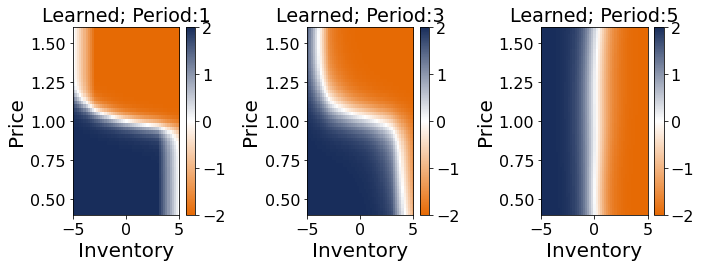


*** Method =  CVaR  ***

*** Loading trained model completed! ***
*** Testing phase completed! ***


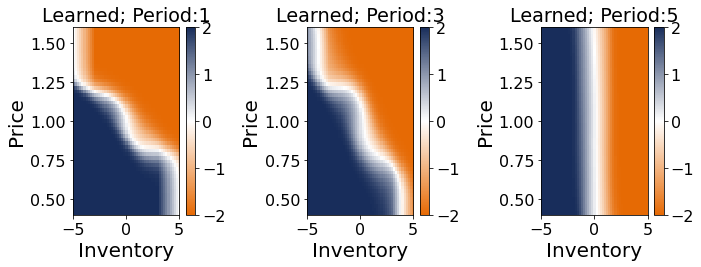


*** Method =  CVaR  ***

*** Loading trained model completed! ***
*** Testing phase completed! ***


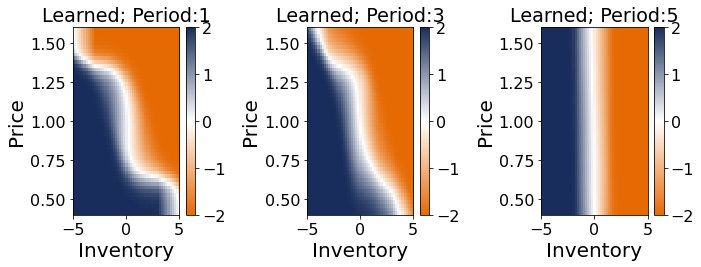

In [7]:
for idx_method, method in enumerate(rm_list):
    # print progress
    print('\n*** Method = ', method, ' ***\n')
    start_time = time.time()
    
    # load the trained model
    actor_critic.policy.load_state_dict(T.load(repo + '/' + rm_labels[idx_method] + '/policy_model.pt'))
    actor_critic.V.load_state_dict(T.load(repo + '/' + rm_labels[idx_method] + '/V_model.pt'))

    # print progress
    print('*** Loading trained model completed! ***')

    ##############################################################################
    ###########################     TESTING PHASE     ############################
    
    # set seed for reproducibility purposes
    T.manual_seed(seed)
    np.random.seed(seed)

    # initialize the starting state
    s, q = env.reset(Nsimulations)
    
    for timestep in env.spaces["t_space"][:-1]:
        # simulate transitions according to the policy
        u, _ = actor_critic.select_actions(s, q, timestep*T.ones(Nsimulations), 'best')
        s, q, cost = env.step(s, q, u)

        # store costs
        costs[:,timestep,idx_method] = cost.detach().numpy()

    # get terminal reward
    costs[:,-1,idx_method] = env.get_final_cost(s, q).detach().numpy()
    
    # print progress
    print('*** Testing phase completed! ***')
    
    ###########################     END OF TESTING     ###########################
    ##############################################################################
    
    ##############################################################################
    ###########################     PLOT: OPTIMAL POLICY     #####################
    plt.figure(figsize=(10,4))
    for time_idx, time_val in enumerate([0, 2, 4]):
        # allocate the subplot
        plt.subplot(1,3,time_idx+1)
        
        # initialize 2D histogram
        hist2dim_pi = np.zeros([len(env.spaces["s_space"]), len(env.spaces["q_space"])])

        for s_idx, s_val in enumerate(env.spaces["s_space"]):
            for q_idx, q_val in enumerate(env.spaces["q_space"]):
                # best action according to the policy
                hist2dim_pi[len(env.spaces["s_space"])-s_idx-1, q_idx], _ = \
                        actor_critic.select_actions(T.Tensor([s_val]).to(actor_critic.device),
                                                    T.Tensor([q_val]).to(actor_critic.device),
                                                    T.tensor([time_val]).to(actor_critic.device),
                                                    'best')

        # plot the 2D histogram
        plt.imshow(hist2dim_pi,
                interpolation='none',
                cmap=utils.cmap,
                extent=[np.min(env.spaces["q_space"]),
                        np.max(env.spaces["q_space"]),
                        np.min(env.spaces["s_space"]),
                        np.max(env.spaces["s_space"])],
                aspect='auto',
                vmin=-env.params["max_u"],
                vmax=env.params["max_u"])
        
        plt.title('Learned; Period:' + str(time_val+1))
        plt.xlabel("Inventory")
        plt.ylabel("Price")
        plt.colorbar()
        plt.tight_layout()
    
    plt.show()
    
    ###########################     PLOT: OPTIMAL POLICY     #####################
    ##############################################################################

## 6. Plotting Additional Figures

In the second part of the testing phase, we now create figures that compare all agents at the same time. In the statistical arbitrage example, a plot of interest is the distribution of terminal wealth when following the optimal policy for all dynamic risk measures.

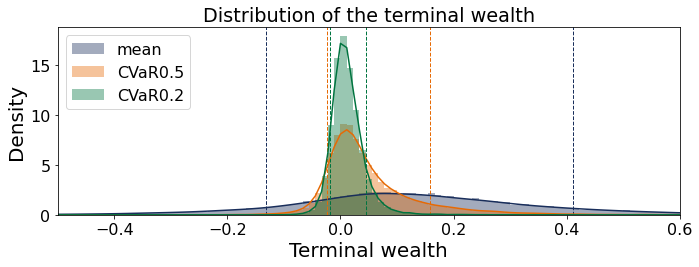

In [8]:
# plot rewards instead of costs
rewards_total = -1 * np.sum(costs, axis=1)

# set a grid for the histogram
grid = np.linspace(-0.5, 0.6, 100)

##############################################################################
###########################     PLOT: TERMINAL COST     ######################

plt.figure(figsize=(10,4))
for idx_method, method in enumerate(rm_list):
    # plot the histogram for each method
    reward = rewards_total[:,idx_method]
    plt.hist(x=rewards_total[:,idx_method],
            alpha=0.4,
            bins=grid,
            color=utils.colors[idx_method],
            density=True)

plt.legend(rm_labels)
plt.xlabel("Terminal wealth")
plt.ylabel("Density")
plt.title("Distribution of the terminal wealth")

for idx_method, method in enumerate(rm_list):
    # plot gaussian KDEs
    kde = gaussian_kde(rewards_total[:,idx_method], bw_method='silverman')
    plt.plot(grid,
            kde(grid),
            color=utils.colors[idx_method],
            linewidth=1.5)
    # plot quantiles of the distributions
    plt.axvline(x=np.quantile(rewards_total[:,idx_method],0.1),
                linestyle='dashed',
                color=utils.colors[idx_method],
                linewidth=1.0)
    plt.axvline(x=np.quantile(rewards_total[:,idx_method],0.9),
                linestyle='dashed',
                color=utils.colors[idx_method],
                linewidth=1.0)

plt.xlim(-0.5, 0.6)
plt.tight_layout()
plt.show()

###########################     PLOT: TERMINAL COST     ######################
##############################################################################